In [371]:
import sys
sys.path.append('/workspaces/bha2/src')

In [372]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [659]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list, set_link_color_palette
from matplotlib import colors
from nilearn.image import iter_img


In [374]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [375]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [376]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [377]:
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()

atlas_nonzero = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],1))
print(atlas_nonzero.shape)
old_rois = np.arange(1, atlas_vol.max()+1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)

for idx, rois in enumerate(old_rois):
    atlas_nonzero[atlas_vol == rois] = idx+1

atlas_nonzero_img = nib.Nifti1Image(atlas_nonzero, affine=atlas.affine)

(91, 109, 91, 1)


In [556]:
tree_min = 2
tree_max = 200

g=0.8
opt_level=47
W = matrix_fusion(g, fcm_bin, scm_bin)
t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")

['cadetblue', 'lawngreen', 'sienna', 'crimson', 'darkkhaki', 'yellow', 'slateblue', 'orchid', 'chartreuse', 'springgreen', 'aqua', 'darkslategray', 'orangered', 'lightpink', 'tomato', 'lightblue', 'lightslategray', 'black', 'slategray', 'blueviolet', 'limegreen', 'greenyellow', 'rebeccapurple', 'palegoldenrod', 'mediumaquamarine', 'darksalmon', 'turquoise', 'navy', 'deepskyblue', 'dimgray', 'darkred', 'deeppink', 'green', 'lime', 'forestgreen', 'burlywood', 'lightseagreen', 'cornflowerblue', 'lightslategrey', 'indigo', 'firebrick', 'hotpink', 'brown', 'peru', 'darkgoldenrod', 'seagreen', 'darkslateblue']


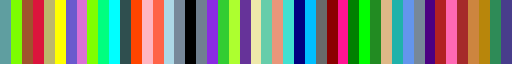

In [760]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    L = pow((pow(rgb[0],2)+pow(rgb[1],2)+pow(rgb[2],2)),0.5) / pow(3,0.5)
    if L < 0.85:
        color_list.append(name)
color_list = list(np.random.choice(color_list, opt_level, replace=False))
cmap_rand = colors.ListedColormap(color_list)
print(color_list)
cmap_rand

/opt/conda/lib/python3.9/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/conda/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/opt/conda/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


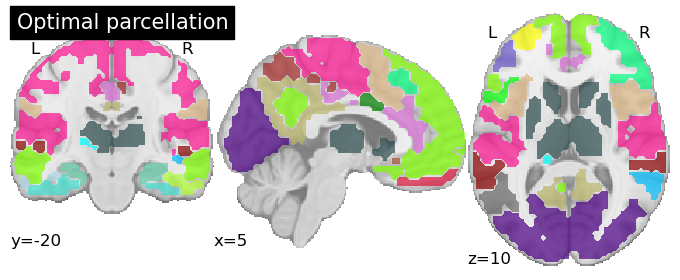

In [769]:
mni_bg = plotting.plot_anat(cut_coords=[5,-20,10], black_bg=False, draw_cross=False, title = "Optimal parcellation")

for mod, c in zip(iter_img(optimal_parcellation), color_list):
    mni_bg.add_contours(mod, linewidths=2., levels=[0.01], filled=True, alpha=0.7,    
                         colors=c)
plt.savefig(os.path.join(project_path, "data", "results", "figures", "opt_parcell_brain.svg"), dpi=300, bbox_inches='tight', format='svg')

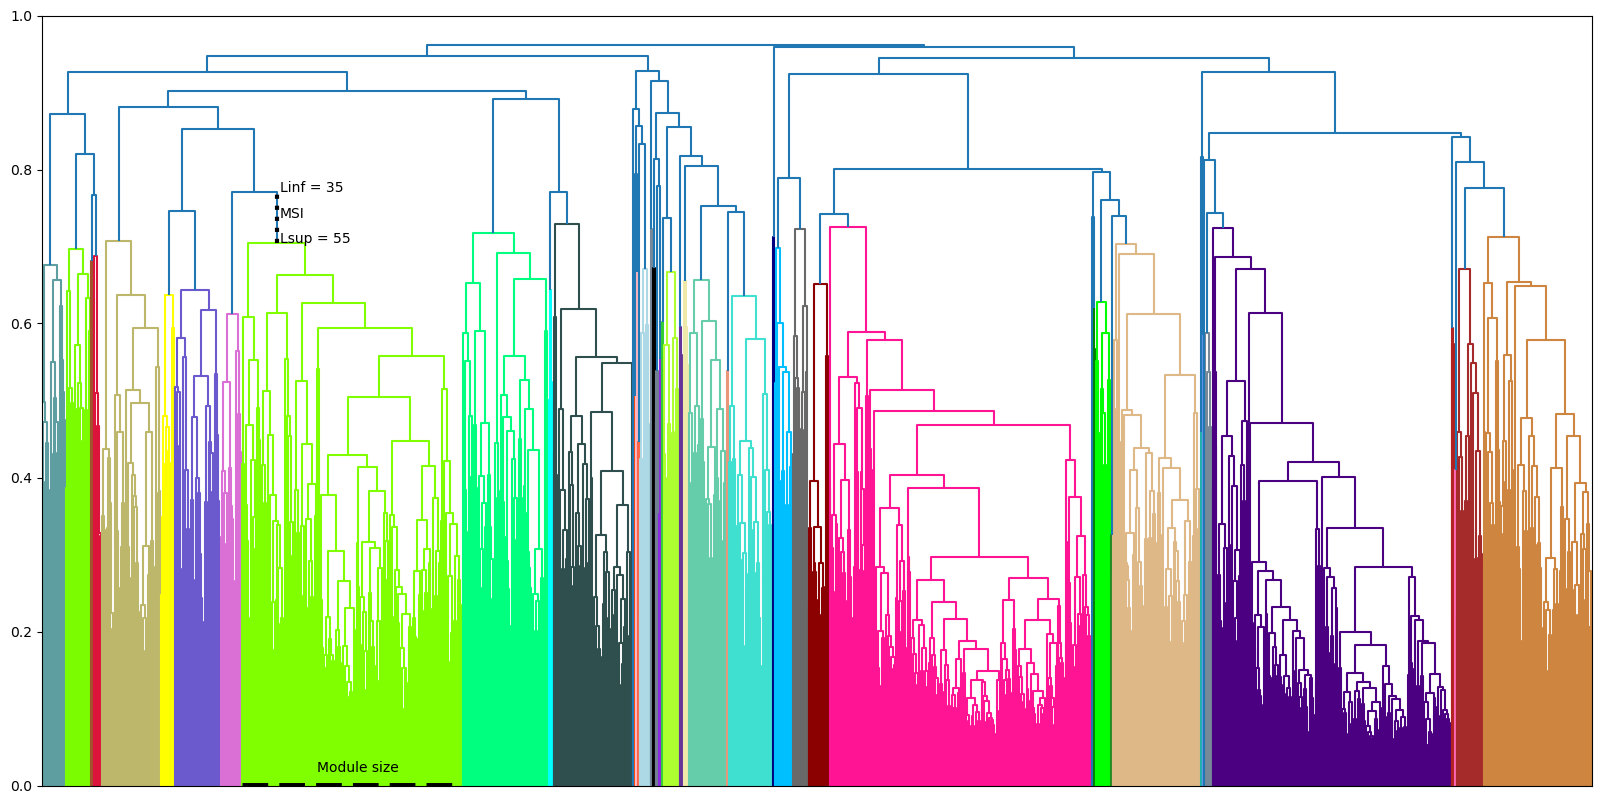

In [762]:
plt.rcParams['figure.figsize'] = [20, 10]

Z = linkage(W, "average")
height_in_tree_sorted = Z[:,2][::-1]

set_link_color_palette(color_list)
den = dendrogram(Z, color_threshold=height_in_tree_sorted[opt_level-2], no_labels=True)

#draw the meaning of duration for example in module 9

module_selected = 9

module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_selected)]
module_presence_in_tree = []
for l in range(2,200):
    level, labels = level_from_tree(t_dict, l)
    for module in level:
            if module == module_rois:
                    module_presence_in_tree.append(l)
                    break

lvl_bf_module = min(module_presence_in_tree)-2
lvl_af_module = max(module_presence_in_tree)-1
min_height = height_in_tree_sorted[lvl_bf_module]
max_height = height_in_tree_sorted[lvl_af_module]

x_loc, y_loc = np.where(np.array(den['dcoord'])==max_height)

x = den['icoord'][x_loc[2]][y_loc[2]]
plt.ylim(0,1)
plt.axvline(x=x, ymin=max_height, ymax=min_height, color='k', ls=':',lw=3)
plt.annotate('MSI', (x, (max_height+min_height)/2), textcoords="offset points", xytext=(2,0), ha='left', color='k')
plt.annotate('Linf = ' + str(lvl_bf_module), (x, min_height), textcoords="offset points", xytext=(2,0), ha='left', color='k')
plt.annotate('Lsup = ' + str(lvl_af_module), (x, max_height), textcoords="offset points", xytext=(2,0), ha='left', color='k')

#draw the meaning of module size for example in module 9
leaves = leaves_list(Z)
loc_in_tree = np.where(np.in1d(leaves, module_rois))[0]
x1 = den['icoord'][loc_in_tree[0]][0]
x2 = den['icoord'][loc_in_tree[-1]][0]
#draw a horizontal line in the bottom of the dendrogram from the first to the last leaf of the module
plt.axhline(y=0, xmin=loc_in_tree[0]/len(leaves), xmax=loc_in_tree[-1]/len(leaves), color='black', ls='--',lw=5)
plt.annotate('Module size', ((x1+x2)/2, 0), 
             textcoords="offset points", xytext=(0,10), ha='center', rotation=0)
plt.savefig(os.path.join(project_path, "data", "results", "figures", "opt_parcell_tree.svg"), dpi=300, bbox_inches='tight', format='svg')

(406,)


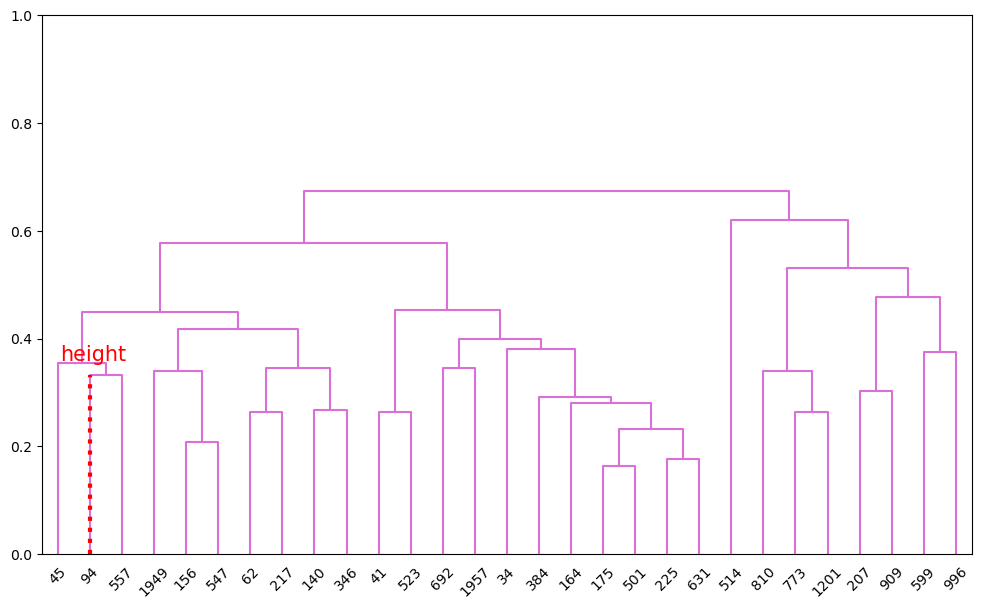

In [765]:
plt.rcParams['figure.figsize'] = [12, 7]

leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1,Z[:,2]))
module_selected = 8

module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_selected)]
loc_in_tree = np.where(np.in1d(leaves, module_rois))[0]
subtree_color = den['leaves_color_list'][loc_in_tree[0]]

W_mod = matrix_fusion(g, fcm_bin[module_rois,:], scm_bin[module_rois,:])
Z_mod = linkage(W_mod, "average")
height_in_tree_sorted_mod = Z_mod[:,2][::-1]
print(W_mod.shape)

# Plot the new dendrogram
den_mod = dendrogram(Z_mod,  color_threshold=0, above_threshold_color=subtree_color, labels=module_rois)

leaves_first_list_sorted_mod = Z_mod[:,0][::-1].astype(int)
leaves_second_list_sorted_mod = Z_mod[:,1][::-1].astype(int)

#draw the meaning of height for roi 4, roi 4 is module_rois[4]
roi_selected = 4
idx_in_first_list_mod = np.where(leaves_first_list_sorted_mod == roi_selected)[0]
idx_in_second_list_mod = np.where(leaves_second_list_sorted_mod == roi_selected)[0]
if idx_in_first_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_first_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod['dcoord'])==roi_height)
    x = den_mod['icoord'][x_loc[0]][y_loc[0]]
elif idx_in_second_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_second_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod['dcoord'])==roi_height)
    x = den_mod['icoord'][x_loc[0]][y_loc[1]]


plt.ylim(0,1)
plt.axvline(x=x, ymin=0, ymax=roi_height, color='r', ls=':',lw=3)
plt.annotate('height', (x, roi_height), textcoords="offset points", xytext=(2,10), ha='center', color='r', fontsize=15)
plt.savefig(os.path.join(project_path, "data", "results", "figures", "opt_parcell_mod_inset_example.svg"), dpi=300, bbox_inches='tight', format='svg')

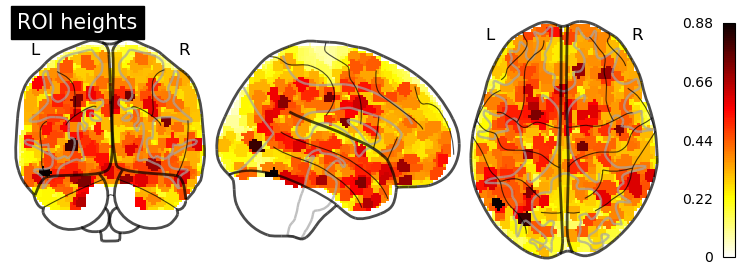

In [389]:
roi_break_heights = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
leaves_first_list_sorted = Z[:,0][::-1].astype(int)
leaves_second_list_sorted = Z[:,1][::-1].astype(int)

roi_heights = []
for roi in range(fcm_bin.shape[1]):
    idx_in_first_list = np.where(leaves_first_list_sorted == roi)[0]
    idx_in_second_list = np.where(leaves_second_list_sorted == roi)[0]
    if idx_in_first_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(atlas_nonzero_img, roi, height_in_tree_sorted[idx_in_first_list[0]])
        roi_heights.append(height_in_tree_sorted[idx_in_first_list[0]])
    elif idx_in_second_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(atlas_nonzero_img, roi, height_in_tree_sorted[idx_in_second_list[0]])
        roi_heights.append(height_in_tree_sorted[idx_in_second_list[0]])
    else:
        print("roi " + str(roi) + " not found")

plotting.plot_glass_brain(nib.Nifti1Image(roi_break_heights, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="ROI heights")
plt.savefig(os.path.join(project_path, "data", "results", "figures", "opt_parcell_roi_heights_brain.svg"), dpi=300, bbox_inches='tight', format='svg')
nib.save(nib.Nifti1Image(roi_break_heights, affine=atlas_nonzero_img.affine),  os.path.join(project_path, "data", "results", "n" + str(conn_size), "roi_breaks_heights.nii.gz"))

Text(0, 0.5, 'ROI height')

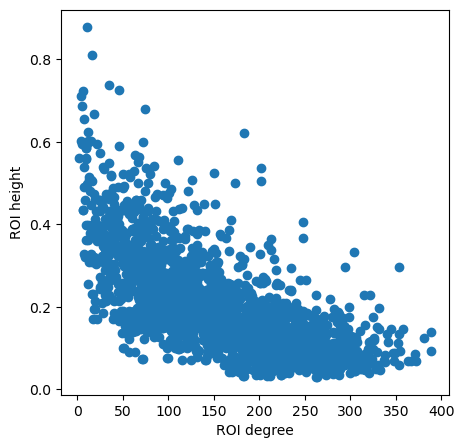

In [408]:
cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
strength_fullmat = cc.sum(axis=0, dtype=float)
plt.scatter(strength_fullmat,roi_heights)
plt.xlabel("ROI degree")
plt.ylabel("ROI height")

Text(0, 0.5, 'Multi-scale Index (MSI)')

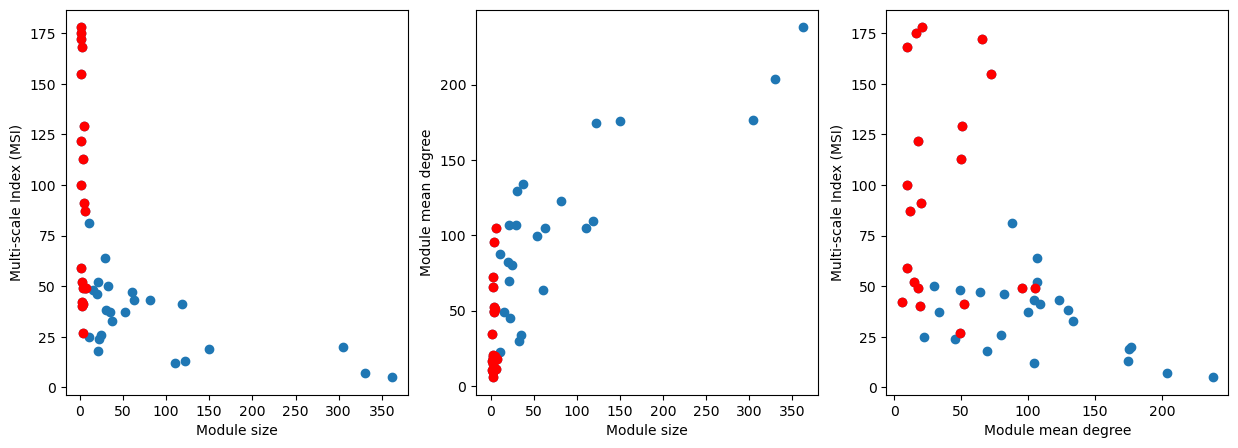

In [755]:
module_MSI = []
module_mean_degree = []
module_size = []

for module_indices in range(1,opt_level+1):
        module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
        module_mean_degree.append(strength_fullmat[module_rois].mean())
        module_presence_in_tree = []
        for l in range(2,200):
                        level, labels = level_from_tree(t_dict, l)
                        for module in level:
                                if module == module_rois:
                                        module_presence_in_tree.append(l)
                                        break
        if len(module_rois) > 1:
                module_MSI.append(len(module_presence_in_tree))
                module_size.append(len(module_rois))
        else:
                module_MSI.append(np.nan) #sustituir el hardcodeo
                module_size.append(1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(module_size, module_MSI)
axs[0].scatter(np.array(module_size)[np.array(module_size)<=10], np.array(module_MSI)[np.array(module_size)<=10], color='r')
axs[0].set_xlabel("Module size")
axs[0].set_ylabel("Multi-scale Index (MSI)")
axs[1].scatter(module_size, module_mean_degree)
axs[1].scatter(np.array(module_size)[np.array(module_size)<=10], np.array(module_mean_degree)[np.array(module_size)<=10], color='r')
axs[1].set_xlabel("Module size")
axs[1].set_ylabel("Module mean degree")
axs[2].scatter(module_mean_degree, module_MSI)
axs[2].scatter(np.array(module_mean_degree)[np.array(module_size)<=10], np.array(module_MSI)[np.array(module_size)<=10], color='r')
axs[2].set_xlabel("Module mean degree")
axs[2].set_ylabel("Multi-scale Index (MSI)")

Text(0, 0.5, 'Module heights')

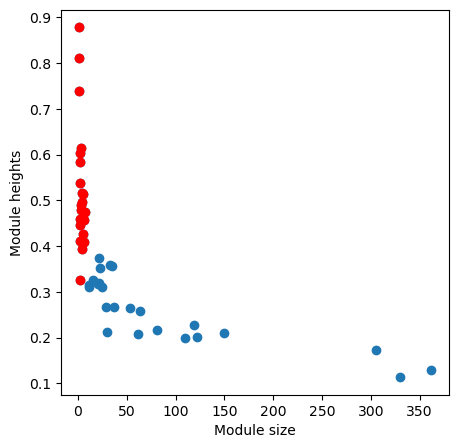

In [753]:
plt.rcParams['figure.figsize'] = [5, 5]

module_heights = []
module_size = []
for module_indices in range(1,opt_level+1):
        module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
        module_size.append(len(module_rois))
        heights_from_first_list = height_in_tree_sorted[np.where(np.in1d(leaves_first_list_sorted, module_rois))[0]]
        heights_from_second_list = height_in_tree_sorted[np.where(np.in1d(leaves_second_list_sorted, module_rois))[0]]
        module_heights.append(np.mean(np.hstack((heights_from_first_list, heights_from_second_list))))

plt.scatter(module_size, module_heights)
plt.scatter(np.array(module_size)[np.array(module_size)<=10], np.array(module_heights)[np.array(module_size)<=10], color='r')
plt.xlabel("Module size")
plt.ylabel("Module heights")

In [745]:
np.where(np.array(module_size) <= 11, 1, 0)

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0])

Text(0, 0.5, 'Module heights')

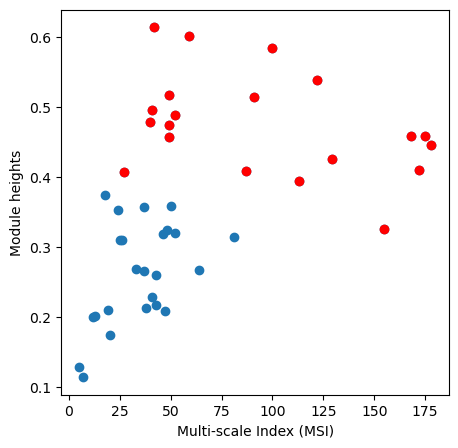

In [756]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.scatter(module_MSI, module_heights)
plt.scatter(np.array(module_MSI)[np.array(module_size)<=10], np.array(module_heights)[np.array(module_size)<=10], color='r')
plt.xlabel("Multi-scale Index (MSI)")
plt.ylabel("Module heights")

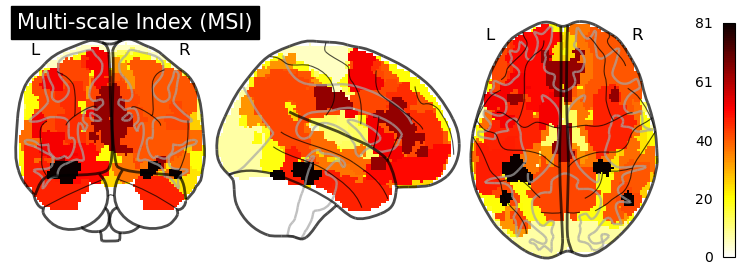

In [757]:
module_MSI = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
    if len(module_rois) > 10:
        module_MSI = module_MSI + get_module_vol(atlas_nonzero_img, module_rois, module_duration[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_MSI, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Multi-scale Index (MSI)")
plt.savefig(os.path.join(project_path, "data", "results", "figures", "opt_parcell_module_MSI_brain.svg"), dpi=300, bbox_inches='tight', format='svg')
nib.save(nib.Nifti1Image(module_MSI, affine=atlas_nonzero_img.affine),  os.path.join(project_path, "data", "results", "n" + str(conn_size), "MSI.nii.gz"))


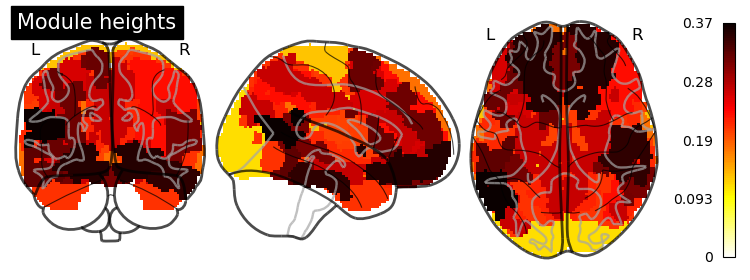

In [767]:
module_heights_img = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
    if len(module_rois) > 10:
        module_heights_img = module_heights_img + get_module_vol(atlas_nonzero_img, module_rois, module_heights[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_heights_img, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module heights")
nib.save(nib.Nifti1Image(module_heights_img, affine=atlas_nonzero_img.affine),  os.path.join(project_path, "data", "results", "n" + str(conn_size), "module_heights.nii.gz"))
plt.savefig(os.path.join(project_path, "data", "results", "figures", "opt_parcell_module_heights_brain.svg"), dpi=300, bbox_inches='tight', format='svg')


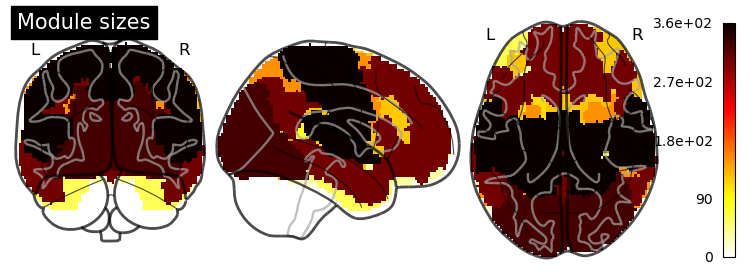

In [759]:
module_size_img = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
    if len(module_rois) > 10:
        module_size_img = module_size_img + get_module_vol(atlas_nonzero_img, module_rois, module_size[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_size_img, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module sizes")
nib.save(nib.Nifti1Image(module_size_img, affine=atlas_nonzero_img.affine),  os.path.join(project_path, "data", "results", "n" + str(conn_size), "module_sizes.nii.gz"))

In [770]:
sum(np.where(np.array(module_size) <= 10, 1, 0))

23